In [97]:
using Knet
# Test if Knet is using gpu
Knet.gpu()

0

In [98]:
using Pkg;

# Install missing packages
for p in ["Knet", "MLJ", "MLJModels", "Distributions", "Plots", "NPZ"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end

using Knet, Plots, Random,  MLJ, Distributions, LinearAlgebra, NPZ

In [99]:
atype = (Knet.gpu()>=0 ? Knet.KnetArray{Float32} : Array{Float32})

KnetArray{Float32,N} where N

In [100]:
struct Mask; d; reverse; end

#one argument: mask 
#two argument: unmask 
function (mask::Mask)(x) 
    len = size(x, 1)
    b = convert(atype,zeros(len,1))
    d = mask.d
    if mask.reverse 
        b[d+1:end,1] .= 1
    else
        b[1:d,1] .= 1
    end
    x_id = x .* b
    x_change = x .* (1 .- b)
    return x_id, x_change
end
function (mask::Mask)(y_id, y_change)
    len = size(y_id, 1)
    b = convert(atype,zeros(len,1))
    d = mask.d
    if mask.reverse 
        b[d+1:end,1] .= 1
    else
        b[1:d,1] .= 1
    end
    return y_id .* b + y_change .* (1 .- b)
end


struct Sequential
    layers
    Sequential(layers...) = new(layers)
end
(s::Sequential)(x) = (for l in s.layers; x = l(x); end; x)

struct DenseLayer; w; b; f; end

DenseLayer(i::Int,o::Int, f=relu) = DenseLayer(param(o,i), param0(o), f)

(d::DenseLayer)(x) = d.f.(d.w * x .+ d.b)



#Coupling Layer
mutable struct CouplingLayer; st_net::Sequential; mask::Mask; logdet; end

function CouplingLayer(;in_dim::Int, hidden_dim::Int, num_layers::Int, mask::Mask)
    layers = []
    push!(layers, DenseLayer(in_dim, hidden_dim, relu))
    for layer in 1:num_layers
        push!(layers, DenseLayer(hidden_dim, hidden_dim, relu))
    end
    push!(layers, DenseLayer(hidden_dim, 2*in_dim, identity))
    st_net = Sequential(layers...)
    CouplingLayer(st_net, mask, 0.0)
end

function (cpl::CouplingLayer)(x)
    x_id, x_change, s, t = get_s_and_t(cpl, x)
#     y_change = x_change .* exp.(s) .+ t #in original code, first addition is performed, then exponentiation
    y_change = (x_change .+ t) .* exp.(s) 
    y_id = x_id
    cpl.logdet = sum(s; dims=1)
    return cpl.mask(y_id, y_change)
end
#st is a neural network, the first part of the output is used as s, second part as t
function get_s_and_t(cpl::CouplingLayer, x)
    x_id, x_change = cpl.mask(x)
    st = cpl.st_net(x_id)
    middle = (size(st)[1]+1)÷2
    s, t = st[1:middle,:], st[middle+1:end,:]
    s = tanh.(s)
    return (x_id, x_change, s, t)
end


struct RealNVP; seq::Sequential; end

function RealNVP(;in_dim::Int, hidden_dim::Int, num_coupling_layers::Int, num_hidden_layers::Int)
    coupling_layers = []
    for i in 1:num_coupling_layers
        push!(coupling_layers, CouplingLayer(;in_dim=in_dim, hidden_dim=hidden_dim, num_layers=num_hidden_layers, mask=Mask(div(in_dim,2), Bool((i+1) %2))))
    end
    seq = Sequential(coupling_layers...)
    RealNVP(seq)
end

(realnvp::RealNVP)(x) = realnvp.seq(x)


function inverse(realnvp::RealNVP, z)
    return inverse(realnvp.seq, z)
end
function inverse(seq::Sequential, z)
    for layer in reverse(seq.layers)
        z = inverse(layer, z)
    end
    return z
end
function inverse(cpl::CouplingLayer, z)
    x_id, x_change, s, t = get_s_and_t(cpl, z)
#     y_change = x_change .* exp.(s) .+ t #in original code, first addition is performed, then exponentiation
    y_change = (x_change .* exp.(s*(-1))) .- t 
    y_id = x_id
    cpl.logdet = sum(s; dims=1)
    return cpl.mask(y_id, y_change)
end

function logdet(realNVP::RealNVP)
    total_logdet = 0.0
    for cpl in realNVP.seq.layers
        total_logdet = total_logdet .+ cpl.logdet
    end
    return total_logdet
end

logdet (generic function with 1 method)

In [101]:
function make_moons_ssl()
    Knet.seed!(2020)
    Random.seed!(2020)
    n_samples = 1000
    data = MLJ.make_moons(n_samples;noise=0.05)
    data = convert(atype, permutedims(hcat(data[1][1], data[1][2])))
    labels = convert(atype, ones(1,n_samples)) * (-1)
    idx1 = [2 3 6 19 33]
    labels[idx1] .= 1
    idx0 = [1 4 8 9 35]
    labels[idx0] .= 0
    return data, labels
end

make_moons_ssl (generic function with 1 method)

In [102]:
function mylogpdf(g,x)
    xx = convert(Array{Float32}, Knet.value(x))
    ans = Distributions.logpdf(g, xx)
    return convert(atype, ans)
end

function mygradlogpdf(g,x)
    xx = convert(Array{Float32}, Knet.value(x))
    ans = []
    for i in 1:size(xx,2)
        push!(ans, Distributions.gradlogpdf(g,xx[:,i]))
    end
    ans = hcat(ans...)
    return convert(atype, ans) 
end

@Knet.primitive mylogpdf(g,x),dy 1 reshape(dy, (1,length(dy))).*mygradlogpdf(g,x) 

In [103]:
struct Prior; means; n_components; d; gaussians; weights; end
#n_components: number of classes
#d: feature dimension of data points
#means: d x n_components
#gaussians: we have n_components multivariate-gaussians, each with size d
function Prior(means)
    d, n_components = size(means)
    weights = convert(atype, ones(1, n_components))
    gaussians = []
    for i in 1:n_components
        mu = means[:,i]
        sig = Matrix{Float64}(I, d, d)
        push!(gaussians, MvNormal(mu, sig))
    end
    Prior(means, n_components, d, gaussians, weights)
end

function log_prob(prior::Prior, z, labels=nothing; label_weight=1.0)
    all_log_probs = []
    for g in prior.gaussians
        push!(all_log_probs, mylogpdf(g, z))
    end
    all_log_probs = hcat(all_log_probs...) #n_instances x n_components
    mixture_log_probs = logsumexp(all_log_probs .+ log.(softmax(prior.weights)); dims=2)
    if labels == nothing
        return mixture_log_probs
    else
        #log_probs = convert(atype, zeros(size(mixture_log_probs)))
        len = size(mixture_log_probs, 1)
        int_labels = permutedims(convert(Array{Int32}, labels))
        c_mixture = convert(atype, zeros(len,1))
        mask_mixture = [index[1] for index in findall(label->label==-1, int_labels)]
        c_mixture[mask_mixture,1] .= 1
        log_probs = c_mixture .* mixture_log_probs
        for i in 1:prior.n_components
            c_all_log_probs = convert(atype, zeros(len,1))
            mask = [index[1] for index in findall(label->label==(i-1), int_labels)]
            c_all_log_probs[mask] .=  label_weight
            log_probs += (c_all_log_probs .* all_log_probs[:,i:i])
        end  
        return log_probs
    end
end

log_prob (generic function with 2 methods)

In [104]:
function flow_loss(z, logdet, labels, prior; k=256)
    prior_ll = log_prob(prior, z, labels)
    #I dont know why we are doing this correction
    batch_size = size(z,2)
    kk = length(z) / batch_size
    
    corrected_prior_ll = prior_ll .- log(k) * kk
    if logdet == 0
        ll = corrected_prior_ll
    else
        ll = corrected_prior_ll + permutedims(logdet)
    end
    nll = -mean(ll)
    return nll
end

flow_loss (generic function with 1 method)

In [105]:
function forward(realnvp, data, labels, prior)
    z = realnvp(data)
    sldj = logdet(realnvp)
    return flow_loss(z, sldj, labels, prior)
end

forward (generic function with 1 method)

In [106]:
data, labels = make_moons_ssl()
prior = Prior([-3.5 3.5; -3.5 3.5])
realnvp = RealNVP(in_dim=2, hidden_dim=512, num_coupling_layers=5, num_hidden_layers=1)

lr = 1e-4
epochs = 8001

num_unlabeled = Int(sum(labels .== -1))
num_labeled = size(labels)[2] - num_unlabeled
batch_size = num_labeled
print_freq = 500

int_labels = convert(Array{Int32}, labels)

mask_labeled = [index[2] for index in findall(label->label!=-1, int_labels)]
labeled_data = data[:,mask_labeled]
labeled_labels = labels[mask_labeled]

mask_unlabeled = [index[2] for index in findall(label->label==-1, int_labels)]
unlabeled_data = data[:, mask_unlabeled]
unlabeled_labels = labels[mask_unlabeled]

for p in Knet.params(realnvp)
    p.opt = Adam(;lr=lr)
end

for epoch in 1:epochs
    batch_idx = Distributions.sample(1:num_unlabeled, batch_size, replace=false)
    batch_x, batch_y = unlabeled_data[:, batch_idx], unlabeled_labels[batch_idx]
    batch_x = hcat(batch_x, labeled_data)
    batch_y = vcat(batch_y, labeled_labels)
    batch_y = reshape(batch_y, (1, size(batch_y)[1]))

    loss = @diff forward(realnvp, batch_x, batch_y, prior)
     
    for p in Knet.params(realnvp)
        g = Knet.grad(loss, p)
        update!(Knet.value(p), g, p.opt)
    end
    if epoch % print_freq == 1
        print("iter ")
        print(epoch)
        print(" loss: ")
        print(loss)
        println(" ")
    end
    if epoch == Int(floor(epochs * 0.5)) || epoch == Int(floor(epochs * 0.8))
        lr /= 10
        for p in Knet.params(realnvp)
            p.opt = Adam(;lr=lr)
        end
    end
end

iter 1 loss: T(24.641) 
iter 501 loss: T(7.04149) 
iter 1001 loss: T(6.63033) 
iter 1501 loss: T(6.1806045) 
iter 2001 loss: T(6.3952594) 
iter 2501 loss: T(6.5269356) 
iter 3001 loss: T(5.958093) 
iter 3501 loss: T(6.1390033) 
iter 4001 loss: T(6.085853) 
iter 4501 loss: T(6.031603) 
iter 5001 loss: T(5.651787) 
iter 5501 loss: T(5.968685) 
iter 6001 loss: T(5.732054) 
iter 6501 loss: T(6.380343) 
iter 7001 loss: T(5.843481) 
iter 7501 loss: T(6.0211997) 
iter 8001 loss: T(6.20331) 


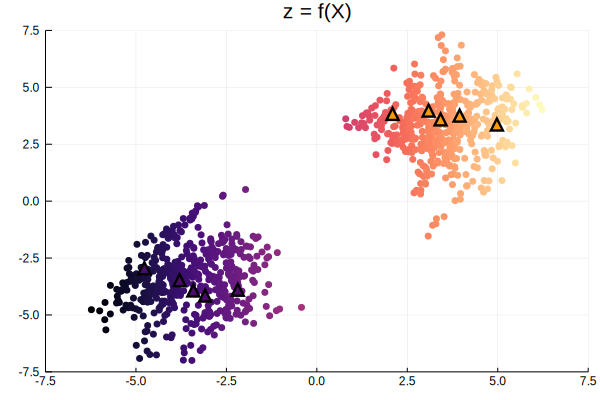

In [107]:
inv = realnvp(data)
xs = convert(Array{Float32}, inv[1,:])
ys = convert(Array{Float32}, inv[2,:])
p1 = plot(xs, ys, title="z = f(X)", seriestype = :scatter, xlim=(-7.5, 7.5), ylim=(-7.5,7.5), m = :magma, zcolor = xs, markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, inv[1,m])
    ys = convert(Array{Float32}, inv[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p1

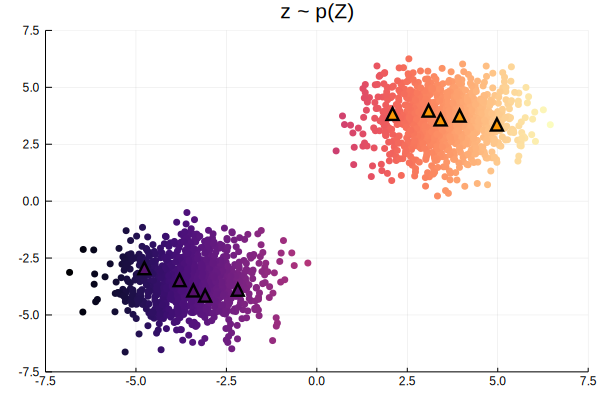

In [108]:
n_samples = 1000
zs = zeros(2, n_samples*prior.n_components)
for i in 1:prior.n_components
    for j in 1:n_samples
        z = Distributions.rand(prior.gaussians[i])
        zs[:,(i-1)*n_samples+j] = z
    end
end

p2 = plot(zs[1,:], zs[2,:], title="z ~ p(Z)", seriestype = :scatter, xlim=(-7.5, 7.5), ylim=(-7.5,7.5), m = :magma, zcolor = zs[1,:], markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, inv[1,m])
    ys = convert(Array{Float32}, inv[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p2

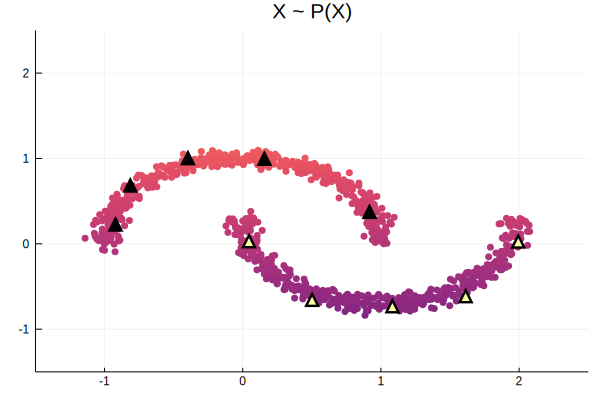

In [109]:
xs = convert(Array{Float32}, data[1,:])
ys = convert(Array{Float32}, data[2,:])
p3 = plot(xs, ys, title="X ~ P(X)", seriestype = :scatter, xlim=(-1.5, 2.5), ylim=(-1.5,2.5), m = :magma, zcolor = ys, markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, data[1,m])
    ys = convert(Array{Float32}, data[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p3

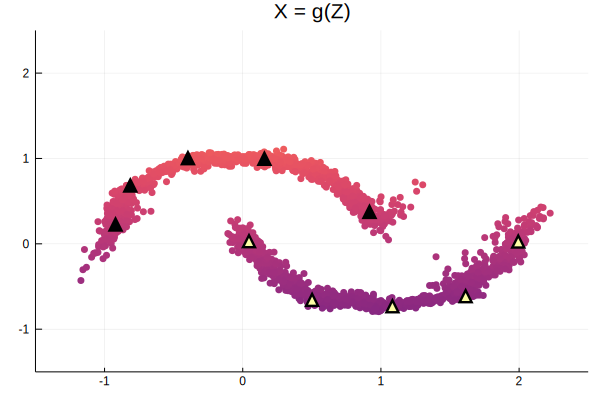

In [110]:
xs = convert(Array{Float32}, inverse(realnvp, convert(atype, zs)))
p4 = plot(xs[1,:], xs[2,:], title="X = g(Z)", seriestype = :scatter, xlim=(-1.5, 2.5), ylim=(-1.5,2.5), m = :magma, zcolor = xs[2,:], markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, data[1,m])
    ys = convert(Array{Float32}, data[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p4

In [111]:
function grid_image(realnvp::RealNVP, xx, yy)
    #size(xx) = size(yy) = (150, 150)
    lines = vcat(reshape(xx, (1, length(xx))), reshape(yy, (1, length(yy))))
    lines = convert(atype, lines)
    img_lines = realnvp(lines)
    img_xx, img_yy = img_lines[1,:], img_lines[2,:]
    img_xx = convert(Array{Float32}, reshape(img_xx, size(xx)))
    img_yy = convert(Array{Float32}, reshape(img_yy, size(yy)))
    return img_xx, img_yy
end

function class_logits(prior::Prior, x)
    log_probs = []
    for g in prior.gaussians
        push!(log_probs, mylogpdf(g, x))
    end
    log_probs = hcat(log_probs...) #n_instances x n_components
    log_probs_weighted = log_probs .+ log.(softmax(prior.weights))
    return log_probs_weighted
end

function classify(prior::Prior, x)
    log_probs = class_logits(prior, x)
    return [arg[2]-1 for arg in argmax(log_probs, dims=2)]
end

function get_decision_boundary(f_xx, f_yy, prior)
    f_points =  vcat(reshape(f_xx, (1, length(f_xx))), reshape(f_yy, (1, length(f_yy))))
    classes = classify(prior, f_points)
    return classes
end


get_decision_boundary (generic function with 1 method)

In [ ]:
grid_points = 150
xx_x = zeros(grid_points, grid_points)
yy_x = zeros(grid_points, grid_points)
step = (2.5+1.5)/(grid_points-1)
for i in 1:grid_points
    for j in 1:grid_points
        xx_x[i,j] = -1.5 + (i-1)*step
        yy_x[i,j] = -1.5 + (j-1)*step
    end
end
f_xx, f_yy = grid_image(realnvp, xx_x, yy_x)

┌ Warning: rainbow is found in more than one library: misc, colorcet. Choosing misc
└ @ PlotUtils /kuacc/users/ssafadoust20/.julia/packages/PlotUtils/6AioP/src/color_gradients.jl:40


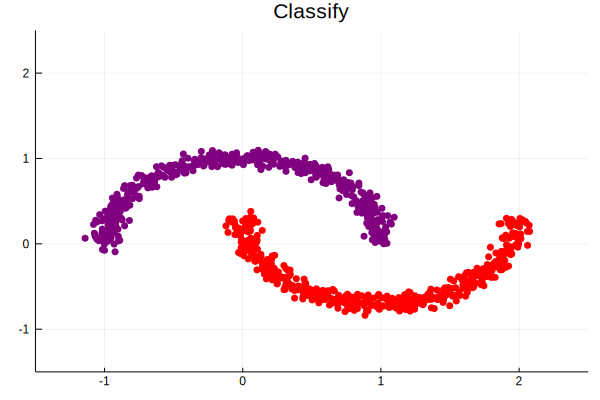

In [112]:
classes = classify(prior, inv)
array_inv = convert(Array{Float32}, inv)
xs = convert(Array{Float32}, data[1,:])
ys = convert(Array{Float32}, data[2,:])
p5 = plot(xs, ys, title="Classify", seriestype = :scatter, xlim=(-1.5, 2.5), ylim=(-1.5,2.5), m = :rainbow, zcolor = classes, markerstrokewidth=0, legend=:none)
p5

In [121]:
function make_circles_ssl()
    Knet.seed!(2020)
    Random.seed!(2020)
    n_samples = 1000
    data = MLJ.make_circles(n_samples; noise=0.05, factor=0.4)
    data = convert(atype, permutedims(hcat(data[1][1], data[1][2])))
    labels = convert(atype, ones(1,n_samples)) * (-1)
    idx1 = [1 4 7 21]
    labels[idx1] .= 1
    idx0 = [2 3 6 16 26 28 33]
    labels[idx0] .= 0
    return data, labels
end

make_circles_ssl (generic function with 1 method)

In [122]:
function get_means(n_classes, r)
    step = 2π/n_classes
    ϕs = collect(0:step:2π)[1:end-1]
    mean_x = reshape(cos.(ϕs) * r, (1,n_classes))
    mean_y = reshape(sin.(ϕs) * r, (1,n_classes))
    means = vcat(mean_x, mean_y)
    return means
end

get_means (generic function with 1 method)

In [123]:
r = 3.5
n_classes = 2
means = get_means(n_classes, r)
prior = Prior(means)

data, labels = make_circles_ssl()

realnvp = RealNVP(in_dim=2, hidden_dim=512, num_coupling_layers=5, num_hidden_layers=1)

lr = 1e-4
epochs = 16001

num_unlabeled = Int(sum(labels .== -1))
num_labeled = size(labels)[2] - num_unlabeled
batch_size = num_labeled
print_freq = 500

int_labels = convert(Array{Int32}, labels)

mask_labeled = [index[2] for index in findall(label->label!=-1, int_labels)]
labeled_data = data[:,mask_labeled]
labeled_labels = labels[mask_labeled]

mask_unlabeled = [index[2] for index in findall(label->label==-1, int_labels)]
unlabeled_data = data[:, mask_unlabeled]
unlabeled_labels = labels[mask_unlabeled]

for p in Knet.params(realnvp)
    p.opt = Adam(;lr=lr)
end

for epoch in 1:epochs
    batch_idx = Distributions.sample(1:num_unlabeled, batch_size, replace=false)
    batch_x, batch_y = unlabeled_data[:, batch_idx], unlabeled_labels[batch_idx]
    batch_x = hcat(batch_x, labeled_data)
    batch_y = vcat(batch_y, labeled_labels)
    batch_y = reshape(batch_y, (1, size(batch_y)[1]))

    loss = @diff forward(realnvp, batch_x, batch_y, prior)
     
    for p in Knet.params(realnvp)
        g = Knet.grad(loss, p)
        update!(Knet.value(p), g, p.opt)
    end
    if epoch % print_freq == 1
        print("iter ")
        print(epoch)
        print(" loss: ")
        print(loss)
        println(" ")
    end
    if epoch == Int(floor(epochs * 0.5)) || epoch == Int(floor(epochs * 0.8))
        lr /= 10
        for p in Knet.params(realnvp)
            p.opt = Adam(;lr=lr)
        end
    end
end

iter 1 loss: T(18.87915) 
iter 501 loss: T(7.2043204) 
iter 1001 loss: T(6.782959) 
iter 1501 loss: T(6.7756653) 
iter 2001 loss: T(6.546983) 
iter 2501 loss: T(7.0228453) 
iter 3001 loss: T(6.516488) 
iter 3501 loss: T(6.3879805) 
iter 4001 loss: T(6.5226607) 
iter 4501 loss: T(6.382459) 
iter 5001 loss: T(6.0608535) 
iter 5501 loss: T(6.177793) 
iter 6001 loss: T(6.3349714) 
iter 6501 loss: T(6.3977623) 
iter 7001 loss: T(6.320045) 
iter 7501 loss: T(6.3053536) 
iter 8001 loss: T(6.4420104) 
iter 8501 loss: T(6.6189327) 
iter 9001 loss: T(6.1843) 
iter 9501 loss: T(6.224527) 
iter 10001 loss: T(6.2975364) 
iter 10501 loss: T(6.0819635) 
iter 11001 loss: T(6.2462296) 
iter 11501 loss: T(6.19219) 
iter 12001 loss: T(7.032113) 
iter 12501 loss: T(6.5244503) 
iter 13001 loss: T(6.2100763) 
iter 13501 loss: T(6.2106075) 
iter 14001 loss: T(6.5728555) 
iter 14501 loss: T(6.003984) 
iter 15001 loss: T(6.278399) 
iter 15501 loss: T(6.064042) 
iter 16001 loss: T(6.156095) 


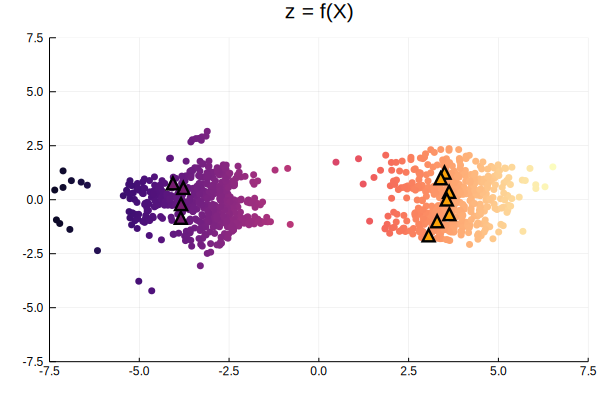

In [124]:
inv = realnvp(data)
xs = convert(Array{Float32}, inv[1,:])
ys = convert(Array{Float32}, inv[2,:])
p1 = plot(xs, ys, title="z = f(X)", seriestype = :scatter, xlim=(-7.5, 7.5), ylim=(-7.5,7.5), m = :magma, zcolor = xs, markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, inv[1,m])
    ys = convert(Array{Float32}, inv[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p1

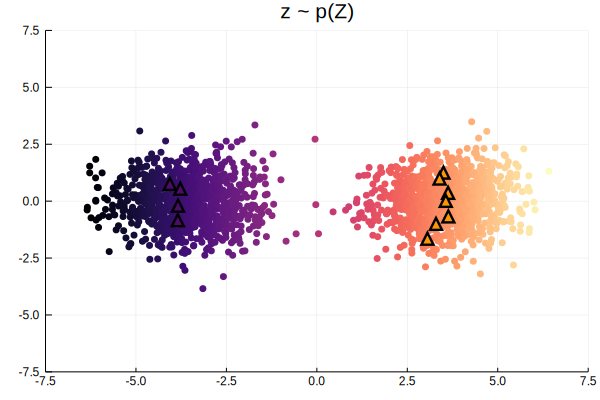

In [125]:
n_samples = 1000
zs = zeros(2, n_samples*prior.n_components)
for i in 1:prior.n_components
    for j in 1:n_samples
        z = Distributions.rand(prior.gaussians[i])
        zs[:,(i-1)*n_samples+j] = z
    end
end

p2 = plot(zs[1,:], zs[2,:], title="z ~ p(Z)", seriestype = :scatter, xlim=(-7.5, 7.5), ylim=(-7.5,7.5), m = :magma, zcolor = zs[1,:], markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, inv[1,m])
    ys = convert(Array{Float32}, inv[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p2

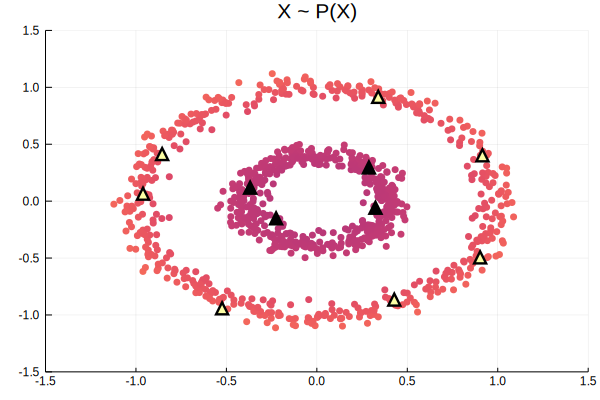

In [126]:
xs = convert(Array{Float32}, data[1,:])
ys = convert(Array{Float32}, data[2,:])
p3 = plot(xs, ys, title="X ~ P(X)", seriestype = :scatter, xlim=(-1.5, 1.5), ylim=(-1.5,1.5), m = :magma, zcolor = xs.^2+ys.^2, markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, data[1,m])
    ys = convert(Array{Float32}, data[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p3

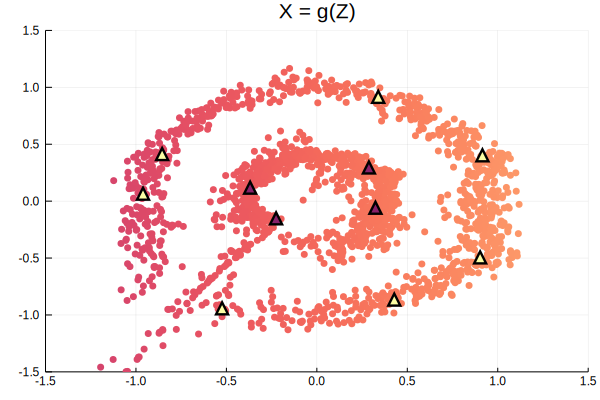

In [127]:
xs = convert(Array{Float32}, inverse(realnvp, convert(atype, zs)))
p4 = plot(xs[1,:], xs[2,:], title="X = g(Z)", seriestype = :scatter, xlim=(-1.5, 1.5), ylim=(-1.5,1.5), m=:magma, zcolor = xs[1,:], markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, data[1,m])
    ys = convert(Array{Float32}, data[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p4

┌ Warning: rainbow is found in more than one library: misc, colorcet. Choosing misc
└ @ PlotUtils /kuacc/users/ssafadoust20/.julia/packages/PlotUtils/6AioP/src/color_gradients.jl:40


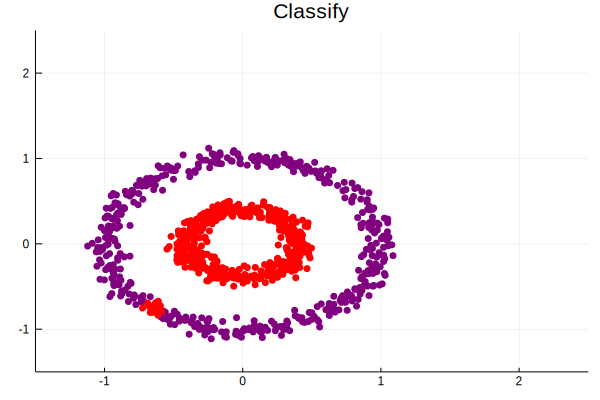

In [128]:
classes = classify(prior, inv)
array_inv = convert(Array{Float32}, inv)
xs = convert(Array{Float32}, data[1,:])
ys = convert(Array{Float32}, data[2,:])
p5 = plot(xs, ys, title="Classify", seriestype = :scatter, xlim=(-1.5, 2.5), ylim=(-1.5,2.5), m = :rainbow, zcolor = classes, markerstrokewidth=0, legend=:none)
p5

In [129]:
r = 5.5
n_classes = 3
means = get_means(n_classes, r)
prior = Prior(means)
eight_gauss = npzread("toy_datasets/8gauss.npz")
data = convert(atype, permutedims(eight_gauss["data"]))
labels = convert(atype, permutedims(eight_gauss["labels"]))


realnvp = RealNVP(in_dim=2, hidden_dim=512, num_coupling_layers=5, num_hidden_layers=1)

lr = 1e-4
epochs = 16001

num_unlabeled = Int(sum(labels .== -1))
num_labeled = size(labels)[2] - num_unlabeled
batch_size = num_labeled
print_freq = 500

int_labels = convert(Array{Int32}, labels)

mask_labeled = [index[2] for index in findall(label->label!=-1, int_labels)]
labeled_data = data[:,mask_labeled]
labeled_labels = labels[mask_labeled]

mask_unlabeled = [index[2] for index in findall(label->label==-1, int_labels)]
unlabeled_data = data[:, mask_unlabeled]
unlabeled_labels = labels[mask_unlabeled]

for p in Knet.params(realnvp)
    p.opt = Adam(;lr=lr)
end

for epoch in 1:epochs
    batch_idx = Distributions.sample(1:num_unlabeled, batch_size, replace=false)
    batch_x, batch_y = unlabeled_data[:, batch_idx], unlabeled_labels[batch_idx]
    batch_x = hcat(batch_x, labeled_data)
    batch_y = vcat(batch_y, labeled_labels)
    batch_y = reshape(batch_y, (1, size(batch_y)[1]))

    loss = @diff forward(realnvp, batch_x, batch_y, prior)
     
    for p in Knet.params(realnvp)
        g = Knet.grad(loss, p)
        update!(Knet.value(p), g, p.opt)
    end
    if epoch % print_freq == 1
        print("iter ")
        print(epoch)
        print(" loss: ")
        print(loss)
        println(" ")
    end
    if epoch == Int(floor(epochs * 0.5)) || epoch == Int(floor(epochs * 0.8))
        lr /= 10
        for p in Knet.params(realnvp)
            p.opt = Adam(;lr=lr)
        end
    end
end

iter 1 loss: T(32.28) 
iter 501 loss: T(9.177216) 
iter 1001 loss: T(8.635811) 
iter 1501 loss: T(8.514076) 
iter 2001 loss: T(8.311707) 
iter 2501 loss: T(8.403796) 
iter 3001 loss: T(8.988215) 
iter 3501 loss: T(8.313481) 
iter 4001 loss: T(8.435035) 
iter 4501 loss: T(8.316553) 
iter 5001 loss: T(8.252073) 
iter 5501 loss: T(8.2387295) 
iter 6001 loss: T(8.663112) 
iter 6501 loss: T(8.28324) 
iter 7001 loss: T(8.490075) 
iter 7501 loss: T(8.52076) 
iter 8001 loss: T(8.437063) 
iter 8501 loss: T(8.338916) 
iter 9001 loss: T(8.185375) 
iter 9501 loss: T(8.294769) 
iter 10001 loss: T(8.550136) 
iter 10501 loss: T(8.274531) 
iter 11001 loss: T(8.142202) 
iter 11501 loss: T(8.399515) 
iter 12001 loss: T(8.102177) 
iter 12501 loss: T(8.159576) 
iter 13001 loss: T(8.169752) 
iter 13501 loss: T(8.352414) 
iter 14001 loss: T(8.545215) 
iter 14501 loss: T(8.334226) 
iter 15001 loss: T(8.767886) 
iter 15501 loss: T(8.264375) 
iter 16001 loss: T(8.151487) 


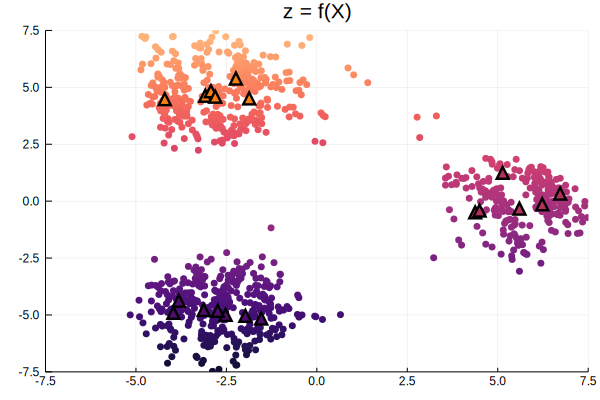

In [130]:
inv = realnvp(data)
xs = convert(Array{Float32}, inv[1,:])
ys = convert(Array{Float32}, inv[2,:])
p1 = plot(xs, ys, title="z = f(X)", seriestype = :scatter, xlim=(-7.5, 7.5), ylim=(-7.5,7.5), m = :magma, zcolor = ys, markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, inv[1,m])
    ys = convert(Array{Float32}, inv[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[2,i], markersize=6, markerstrokewidth=3)
end
p1

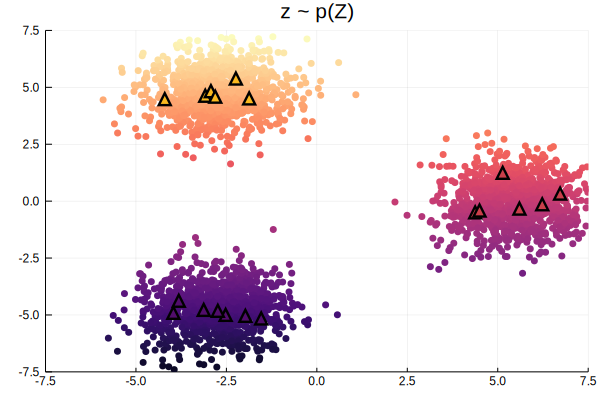

In [131]:
n_samples = 1000
zs = zeros(2, n_samples*prior.n_components)
for i in 1:prior.n_components
    for j in 1:n_samples
        z = Distributions.rand(prior.gaussians[i])
        zs[:,(i-1)*n_samples+j] = z
    end
end

p2 = plot(zs[1,:], zs[2,:], title="z ~ p(Z)", seriestype = :scatter, xlim=(-7.5, 7.5), ylim=(-7.5,7.5), m = :magma, zcolor = zs[2,:], markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, inv[1,m])
    ys = convert(Array{Float32}, inv[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[2,i], markersize=6, markerstrokewidth=3)
end
p2

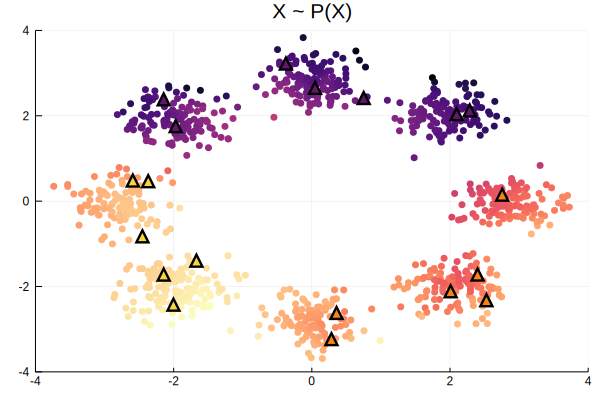

In [135]:
xs = convert(Array{Float32}, data[1,:])
ys = convert(Array{Float32}, data[2,:])
p3 = plot(xs, ys, title="X ~ P(X)", seriestype = :scatter, xlim=(-4, 4), ylim=(-4,4), m = :magma, zcolor = convert(Array{Float32},inv[1,:]+inv[2,:]), markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, data[1,m])
    ys = convert(Array{Float32}, data[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i]+prior.means[2,i], markersize=6, markerstrokewidth=3)
end
p3

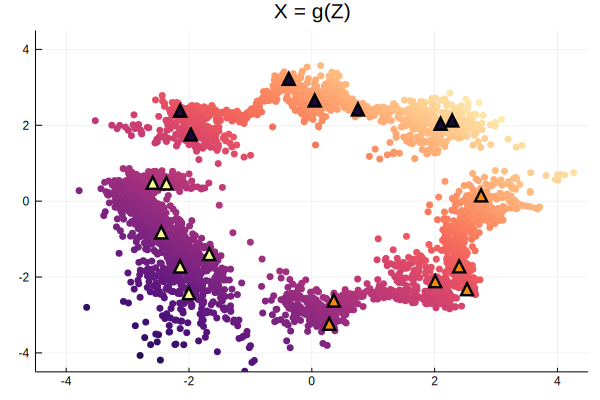

In [137]:
xs = convert(Array{Float32}, inverse(realnvp, convert(atype, zs)))
p4 = plot(xs[1,:], xs[2,:], title="X = g(Z)", seriestype = :scatter, xlim=(-4.5, 4.5), ylim=(-4.5,4.5), m=:magma, zcolor = xs[1,:]+xs[2,:], markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, data[1,m])
    ys = convert(Array{Float32}, data[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i]+prior.means[2,i], markersize=6, markerstrokewidth=3)
end
p4

┌ Warning: rainbow is found in more than one library: misc, colorcet. Choosing misc
└ @ PlotUtils /kuacc/users/ssafadoust20/.julia/packages/PlotUtils/6AioP/src/color_gradients.jl:40


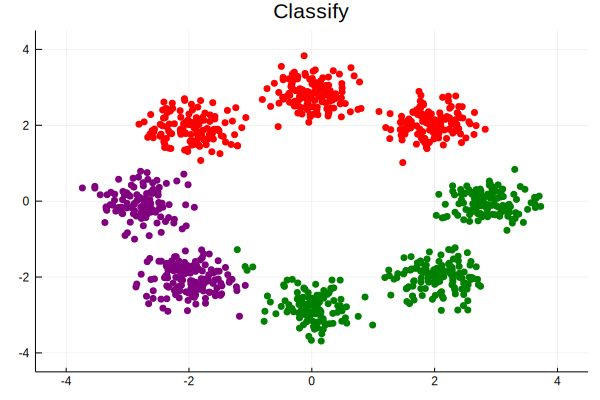

In [138]:
classes = classify(prior, inv)
array_inv = convert(Array{Float32}, inv)
xs = convert(Array{Float32}, data[1,:])
ys = convert(Array{Float32}, data[2,:])
p5 = plot(xs, ys, title="Classify", seriestype = :scatter, xlim=(-4.5, 4.5), ylim=(-4.5,4.5), m = :rainbow, zcolor = classes, markerstrokewidth=0, legend=:none)
p5

In [139]:
r = 5.5
n_classes = 5
means = get_means(n_classes, r)
prior = Prior(means)
pinwheel = npzread("toy_datasets/pinwheel.npz")
data = convert(atype, permutedims(pinwheel["data"]))
labels = convert(atype, permutedims(pinwheel["labels"]))


realnvp = RealNVP(in_dim=2, hidden_dim=512, num_coupling_layers=5, num_hidden_layers=1)

lr = 1e-4
epochs = 16001

num_unlabeled = Int(sum(labels .== -1))
num_labeled = size(labels)[2] - num_unlabeled
batch_size = num_labeled
print_freq = 500

int_labels = convert(Array{Int32}, labels)

mask_labeled = [index[2] for index in findall(label->label!=-1, int_labels)]
labeled_data = data[:,mask_labeled]
labeled_labels = labels[mask_labeled]

mask_unlabeled = [index[2] for index in findall(label->label==-1, int_labels)]
unlabeled_data = data[:, mask_unlabeled]
unlabeled_labels = labels[mask_unlabeled]

for p in Knet.params(realnvp)
    p.opt = Adam(;lr=lr)
end

for epoch in 1:epochs
    batch_idx = Distributions.sample(1:num_unlabeled, batch_size, replace=false)
    batch_x, batch_y = unlabeled_data[:, batch_idx], unlabeled_labels[batch_idx]
    batch_x = hcat(batch_x, labeled_data)
    batch_y = vcat(batch_y, labeled_labels)
    batch_y = reshape(batch_y, (1, size(batch_y)[1]))

    loss = @diff forward(realnvp, batch_x, batch_y, prior)
     
    for p in Knet.params(realnvp)
        g = Knet.grad(loss, p)
        update!(Knet.value(p), g, p.opt)
    end
    if epoch % print_freq == 1
        print("iter ")
        print(epoch)
        print(" loss: ")
        print(loss)
        println(" ")
    end
    if epoch == Int(floor(epochs * 0.5)) || epoch == Int(floor(epochs * 0.8))
        lr /= 10
        for p in Knet.params(realnvp)
            p.opt = Adam(;lr=lr)
        end
    end
end

iter 1 loss: T(21.754053) 
iter 501 loss: T(7.9710603) 
iter 1001 loss: T(7.7244453) 
iter 1501 loss: T(8.314039) 
iter 2001 loss: T(7.7136908) 
iter 2501 loss: T(7.7040668) 
iter 3001 loss: T(7.4700184) 
iter 3501 loss: T(7.322407) 
iter 4001 loss: T(7.3615127) 
iter 4501 loss: T(7.7764955) 
iter 5001 loss: T(7.5239983) 
iter 5501 loss: T(8.090096) 
iter 6001 loss: T(7.6527433) 
iter 6501 loss: T(7.591673) 
iter 7001 loss: T(7.6161947) 
iter 7501 loss: T(7.6559896) 
iter 8001 loss: T(7.4943933) 
iter 8501 loss: T(7.5190587) 
iter 9001 loss: T(7.485076) 
iter 9501 loss: T(7.3501744) 
iter 10001 loss: T(7.463475) 
iter 10501 loss: T(7.636119) 
iter 11001 loss: T(7.2647424) 
iter 11501 loss: T(7.2249923) 
iter 12001 loss: T(7.498627) 
iter 12501 loss: T(7.4036207) 
iter 13001 loss: T(7.2428775) 
iter 13501 loss: T(7.547919) 
iter 14001 loss: T(7.9926043) 
iter 14501 loss: T(7.9137707) 
iter 15001 loss: T(7.6737223) 
iter 15501 loss: T(7.1972094) 
iter 16001 loss: T(7.061561) 


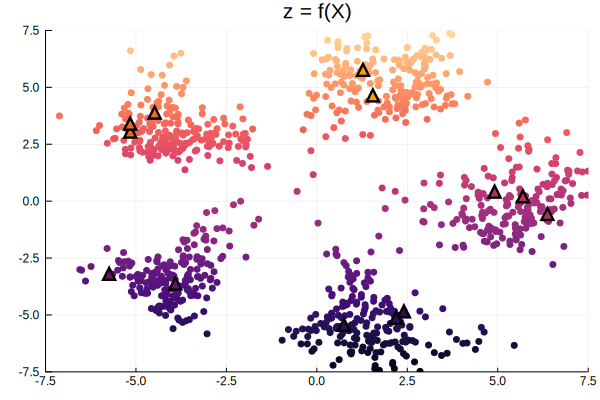

In [140]:
inv = realnvp(data)
xs = convert(Array{Float32}, inv[1,:])
ys = convert(Array{Float32}, inv[2,:])
p1 = plot(xs, ys, title="z = f(X)", seriestype = :scatter, xlim=(-7.5, 7.5), ylim=(-7.5,7.5), m = :magma, zcolor = ys, markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, inv[1,m])
    ys = convert(Array{Float32}, inv[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[2,i], markersize=6, markerstrokewidth=3)
end
p1

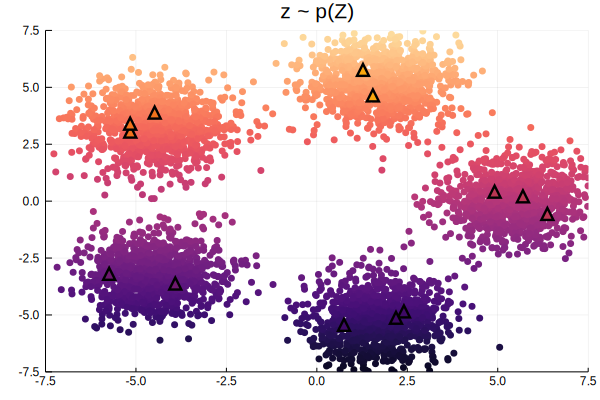

In [141]:
n_samples = 1000
zs = zeros(2, n_samples*prior.n_components)
for i in 1:prior.n_components
    for j in 1:n_samples
        z = Distributions.rand(prior.gaussians[i])
        zs[:,(i-1)*n_samples+j] = z
    end
end

p2 = plot(zs[1,:], zs[2,:], title="z ~ p(Z)", seriestype = :scatter, xlim=(-7.5, 7.5), ylim=(-7.5,7.5), m = :magma, zcolor = zs[2,:], markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, inv[1,m])
    ys = convert(Array{Float32}, inv[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[2,i], markersize=6, markerstrokewidth=3)
end
p2

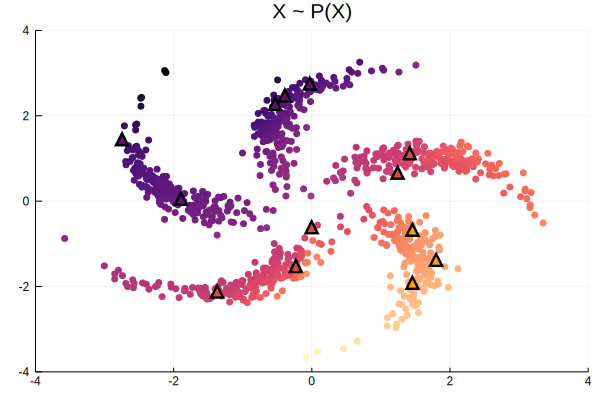

In [142]:
xs = convert(Array{Float32}, data[1,:])
ys = convert(Array{Float32}, data[2,:])
p3 = plot(xs, ys, title="X ~ P(X)", seriestype = :scatter, xlim=(-4, 4), ylim=(-4,4), m = :magma, zcolor = convert(Array{Float32},inv[1,:]), markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, data[1,m])
    ys = convert(Array{Float32}, data[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p3

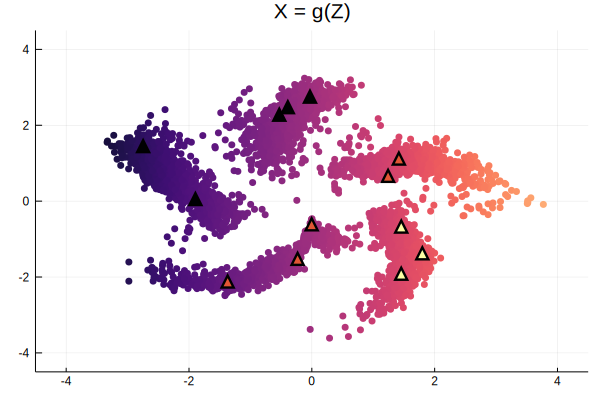

In [143]:
xs = convert(Array{Float32}, inverse(realnvp, convert(atype, zs)))
p4 = plot(xs[1,:], xs[2,:], title="X = g(Z)", seriestype = :scatter, xlim=(-4.5, 4.5), ylim=(-4.5,4.5), m=:magma, zcolor = xs[1,:], markerstrokewidth=0, legend=:none)
for i in 1:(maximum(int_labels)+1)
    m = [index[2] for index in findall(label->label==(i-1), int_labels)]
    xs = convert(Array{Float32}, data[1,m])
    ys = convert(Array{Float32}, data[2,m])
    plot!(xs, ys, seriestype = :scatter, markershape = :utriangle, zcolor=prior.means[1,i], markersize=6, markerstrokewidth=3)
end
p4

┌ Warning: rainbow is found in more than one library: misc, colorcet. Choosing misc
└ @ PlotUtils /kuacc/users/ssafadoust20/.julia/packages/PlotUtils/6AioP/src/color_gradients.jl:40


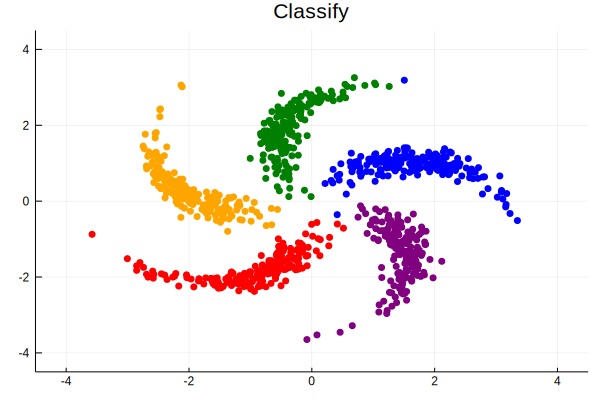

In [144]:
classes = classify(prior, inv)
array_inv = convert(Array{Float32}, inv)
xs = convert(Array{Float32}, data[1,:])
ys = convert(Array{Float32}, data[2,:])
p5 = plot(xs, ys, title="Classify", seriestype = :scatter, xlim=(-4.5, 4.5), ylim=(-4.5,4.5), m = :rainbow, zcolor = classes, markerstrokewidth=0, legend=:none)
p5